In [36]:
from torchvision.transforms import Compose, ToTensor, Normalize, \
Resize, CenterCrop, ToPILImage
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
from PIL import ImageFile, Image

In [2]:
import os
os.chdir('../')

In [3]:
%pwd

'/home/milad/projects/yoga-pose-detection'

In [1]:
# testing notebook

In [4]:
ROOT = 'artifacts/data_ingestion/yoga-poses-dataset/DATASET/'
ImageFile.LOAD_TRUNCATED_IMAGES = True
dataset = load_dataset("imagefolder", data_files={"train": f"{ROOT}/TRAIN/**", "test": f"{ROOT}/TEST/**"}, drop_labels=False)

In [24]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1081
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 470
    })
})

In [5]:
# mapping integer labels to string labels and vv
id2label = dict((k,v) for k,v in enumerate(dataset['train'].features['label'].names))
label2id = dict((v,k) for k,v in enumerate(dataset['train'].features['label'].names))

In [6]:
# processing info for pics
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name) 

In [7]:
mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size

In [8]:
norm = Normalize(mean=mu, std=sigma) #normalize image pixels range to [-1,1]

# resize to 3x224x224 -> convert to Pytorch tensor -> normalize
_transf = Compose([
    Resize(size['height']),
    CenterCrop(size['height']),
    ToTensor(),
    norm
])

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['image']]
    return arg

In [9]:
dataset['train'].set_transform(transf)
dataset['test'].set_transform(transf)

In [10]:
dataset['test'][0]['pixels'].size()

torch.Size([3, 224, 224])

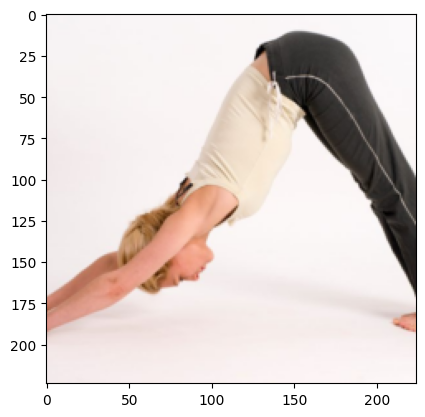

In [25]:
idx = 0
ex = dataset['train'][idx]['pixels']
ex = (ex+1)/2 #imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

In [12]:
# model_name = "google/vit-base-patch16-224"
# model = ViTForImageClassification.from_pretrained(model_name)
# print(model.classifier)

In [13]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(id2label), ignore_mismatched_sizes=True, id2label=id2label, label2id=label2id)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=5, bias=True)


In [15]:
args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

In [16]:
args.report_to = []

In [17]:
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [33]:
trainer = Trainer(
    model,
    args, 
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [19]:
trainer.train()

  0%|          | 0/272 [00:00<?, ?it/s]

 21%|██        | 56/272 [00:16<00:58,  3.69it/s]/home/milad/miniconda3/envs/yoga/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
                                                 
 50%|█████     | 136/272 [00:51<00:33,  4.11it/s]

{'eval_loss': 0.17761120200157166, 'eval_accuracy': 0.9808510638297873, 'eval_runtime': 13.5273, 'eval_samples_per_second': 34.744, 'eval_steps_per_second': 8.723, 'epoch': 1.0}


 56%|█████▌    | 152/272 [00:57<00:40,  2.94it/s]/home/milad/miniconda3/envs/yoga/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
                                                 
100%|██████████| 272/272 [01:44<00:00,  4.03it/s]

{'eval_loss': 0.08557258546352386, 'eval_accuracy': 0.9808510638297873, 'eval_runtime': 13.6752, 'eval_samples_per_second': 34.369, 'eval_steps_per_second': 8.629, 'epoch': 2.0}


100%|██████████| 272/272 [01:46<00:00,  2.56it/s]

{'train_runtime': 106.2134, 'train_samples_per_second': 20.355, 'train_steps_per_second': 2.561, 'train_loss': 0.505342820111443, 'epoch': 2.0}


TrainOutput(global_step=272, training_loss=0.505342820111443, metrics={'train_runtime': 106.2134, 'train_samples_per_second': 20.355, 'train_steps_per_second': 2.561, 'train_loss': 0.505342820111443, 'epoch': 2.0})

In [26]:
trainer.save_model("artifacts/training/")

In [32]:
processor = ViTImageProcessor.from_pretrained("artifacts/training/")
model = ViTForImageClassification.from_pretrained("artifacts/training/")

In [34]:
outputs = trainer.predict(dataset['test'])
print(outputs.metrics)

100%|██████████| 118/118 [00:13<00:00,  8.77it/s]

{'test_loss': 0.17761120200157166, 'test_accuracy': 0.9808510638297873, 'test_runtime': 13.6984, 'test_samples_per_second': 34.311, 'test_steps_per_second': 8.614}


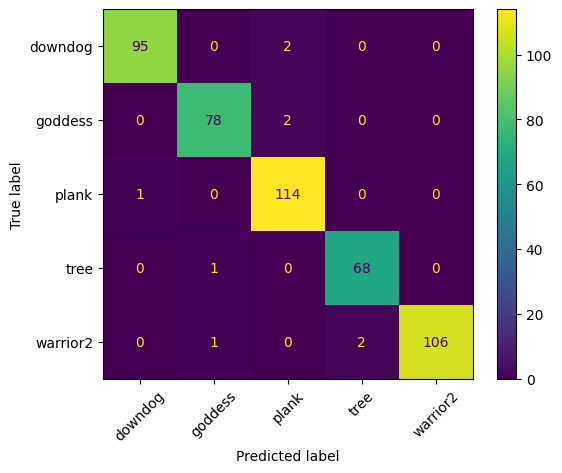

In [21]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = dataset['train'].features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [44]:
path_to_image = 'artifacts/data_ingestion/yoga-poses-dataset/DATASET/TEST/tree/00000006.jpg'
image = Image.open(path_to_image)
inputs = processor(images=image, return_tensors="pt")
inputs.to('cuda')
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: tree
